In [ ]:
pip install wordcloud

In [ ]:
pip install gensim

# **Import**

In [ ]:
import pandas as pd
import wordcloud
from sklearn.feature_extraction.text import TfidfVectorizer

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset_fix.csv')
dataset.head()

Unnamed: 0                       id_review  \
0           0  0AV0mU6Ah4sD7RW2nv0oq6Di3Xk1Xc   
1           1  0De9jM9LB3gz7jp0Uo2Wm5oO0cJ3Gn   
2           2  0EZ7BP9hm1uE7CO9cV7gJ8XX8Fs4aD   
3           3  0Hd8XX7Ag5SZ6OA2PE9Wj1bh8FD5tG   
4           4  0Hi1ad3Jw4ui8gm0Th1xT1EP8Um7xj   

                                  review_clean_cased  \
0  Pernah kesini waktu SD dulu lokasi nya real ma...   
1  Disini pas banget buat piknik bareng keluarga ...   
2  Sudah beberapa kali ke Candi Borobudur Tempatn...   
3  Salah satu tujuan utama ke Yogyakarta adalah k...   
4  Waktu yang tepat untuk mengunjungi borobudur a...   

                                  review_low_uncased  \
0  pernah kesini waktu sd dulu lokasi nya real ma...   
1  disini pas banget buat piknik bareng keluarga ...   
2  sudah beberapa kali ke candi borobudur tempatn...   
3  salah satu tujuan utama ke yogyakarta adalah k...   
4  waktu yang tepat untuk mengunjungi borobudur a...   

                                              review  attractions  amenities  \
0  Pernah kesini waktu SD dulu lokasi nya real ma...            3          0   
1  Disini pas banget buat piknik bareng keluarga ...            3          0   
2  Sudah beberapa kali ke Candi Borobudur. Tempat...            3          3   
3  Salah satu tujuan utama ke Yogyakarta adalah k...            3          0   
4  Waktu yang tepat untuk mengunjungi borobudur a...            0          3   

   access  price  no_aspect  \
0       0      0          3   
1       0      0          3   
2       0      0          0   
3       3      0          2   
4       0      0          2   

                                    attractions_text  \
0  pernah kesini waktu sd dulu lokasi nya real ma...   
1  tempatnya sejuk dan sangat nyaman tempatnya se...   
2  tempatnya bersih terpeihara dilihat dari area ...   
3  tempat yang indah dan menakjubkan salah satu t...   
4                                               none   

                                      amenities_text  \
0                                               none   
1                                               none   
2  tempatnya bersih terpeihara dilihat dari area ...   
3                                               none   
4  waktu yang tepat untuk mengunjungi borobudur a...   

                                         access_text price_text  \
0                                               none       none   
1                                               none       none   
2                                               none       none   
3  sedia ojek payung agar tidak kepanasan sedia o...       none   
4                                               none       none   

                                      no_aspect_text  
0  boleh dicoba tuh kawan boleh dicoba tuh kawan ...  
1  disini pas banget buat piknik bareng keluarga ...  
2                                               none  
3  salah satu tujuan utama ke yogyakarta adalah k...  
4  waktu yang tepat untuk mengunjungi borobudur a...

# **Aspek Access**

### **Text Negatif**

In [ ]:
# Mengambil selain "none" dan mengambil "negatif"
df_access = dataset[(dataset['access'] != 0) & ((dataset['access'] == 1))]
df_access_negative = df_access[['access_text']].values

# ini kalo mau dipisahin stopword sama tokenisasinya, soalnya yg dibawah itu aku gabung
custom_stop_words = ['yang', 'di', 'dan', 'untuk', 'juga', 'ada', 'dari', 'anda', 'ke', 'sudah',
                     'ke', 'sangat', 'ini', 'yg', 'bisa', 'banyak', 'atau', 'dengan', 'lebih', 'kita', 'saya',
                     'tidak', 'salah', 'satu', 'hanya', 'akan', 'dapat', 'karena', 'adalah', 'jadi', 'nya']
              #tambahin kata-kata gapenting disini.

def elim_stopword(text):
    tokens = text.split(" ")
    filtered_tokens = [token for token in tokens if token.lower() not in custom_stop_words]
    joined_text = " ".join(filtered_tokens)

    return joined_text

df_access['access_text'] = df_access['access_text'].apply(lambda x: elim_stopword(x))

teks_negatif = df_access['access_text']
print(teks_negatif)
# df_access_negative.head()

10      berada ketinggian pemandangan sekitar tampak a...
21      apalagi jarak candi pintu keluar parkiran jauh...
25      ntuk candinya perjalanan jauh tetapi pilihan j...
33                           jarak jogja memang agak jauh
36      pengunjung harus berjalan kaki cukup jauh pint...
                              ...                        
1616    candi tersebut harus menaiki tangga tangga men...
1619    pintu gerbang candi lumayan jauh berjalan kaki...
1622    disayangkan jalan keluarnya jauh banget ditamb...
1624    terlalu jauh berjalan kaki terlalu mahal kenda...
1637    lalu terpenting jangan lupa siapkan stamina fi...
Name: access_text, Length: 329, dtype: object


<ipython-input-10-74e6548c146f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_access['access_text'] = df_access['access_text'].apply(lambda x: elim_stopword(x))


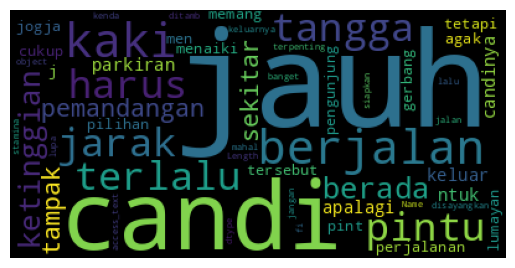

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

wordcloud = WordCloud().generate(str(teks_negatif))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# **LDA Topic Modelling**

In [ ]:
def tokenisasi(text):
    tokens = text.split(" ")
    return tokens

tokens_negatif = [tokenisasi(t) for t in teks_negatif]
print(tokens_negatif)

[['berada', 'ketinggian', 'pemandangan', 'sekitar', 'tampak', 'asri', 'tapi', 'ya', 'jalan', 'menuju', 'candinya', 'mayan', 'jauh', 'orang', 'sepuh', 'mending', 'nunggu', 'taman', 'saja', 'tapi', 'ya', 'jalan', 'menuju', 'candinya', 'mayan', 'jauh', 'tapi', 'ya', 'jalan', 'menuju', 'candinya', 'mayan', 'jauh', 'orang', 'sepuh', 'mending', 'nunggu', 'taman', 'saja'], ['apalagi', 'jarak', 'candi', 'pintu', 'keluar', 'parkiran', 'jauh', 'harus', 'melewati', 'pasar', 'menjual', 'pernak', 'pernik', 'oleh', 'oleh', 'apalagi', 'jarak', 'candi', 'pintu', 'keluar', 'parkiran', 'jauh', 'harus', 'melewati', 'pasar', 'menjual', 'pernak', 'pernik', 'oleh', 'oleh', 'kalau', 'pihak', 'pengelola', 'candi', 'borobudur', 'pintu', 'keluar', 'jangan', 'terlalu', 'jauh', 'kasihan', 'orang', 'membawa', 'anak', 'lansia', 'harus', 'berjalan', 'jauh', 'apalagi', 'jarak', 'candi', 'pintu', 'keluar', 'parkiran', 'jauh', 'harus', 'melewati', 'pasar', 'menjual', 'pernak', 'pernik', 'oleh', 'oleh', 'kalau', 'pihak'

In [ ]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(tokens_negatif)
# Create Corpus
# Term Frequency
corpus = [id2word.doc2bow(text) for text in tokens_negatif]
# View
print(id2word)
print(corpus[:1])

Dictionary<1612 unique tokens: ['asri', 'berada', 'candinya', 'jalan', 'jauh']...>
[[(0, 1), (1, 1), (2, 3), (3, 3), (4, 3), (5, 1), (6, 3), (7, 2), (8, 3), (9, 2), (10, 2), (11, 1), (12, 2), (13, 1), (14, 2), (15, 2), (16, 1), (17, 3), (18, 3)]]


In [ ]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('asri', 1),
  ('berada', 1),
  ('candinya', 3),
  ('jalan', 3),
  ('jauh', 3),
  ('ketinggian', 1),
  ('mayan', 3),
  ('mending', 2),
  ('menuju', 3),
  ('nunggu', 2),
  ('orang', 2),
  ('pemandangan', 1),
  ('saja', 2),
  ('sekitar', 1),
  ('sepuh', 2),
  ('taman', 2),
  ('tampak', 1),
  ('tapi', 3),
  ('ya', 3)]]

In [ ]:
# Build LDA model
import gensim
lda_model = gensim.models.LdaMulticore(corpus=corpus,id2word=id2word,num_topics=5,random_state=100,chunksize=100,passes=10,per_word_topics=True)

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus,id2word=id2word,num_topics=num_topics,random_state=100,chunksize=100,passes=10,per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

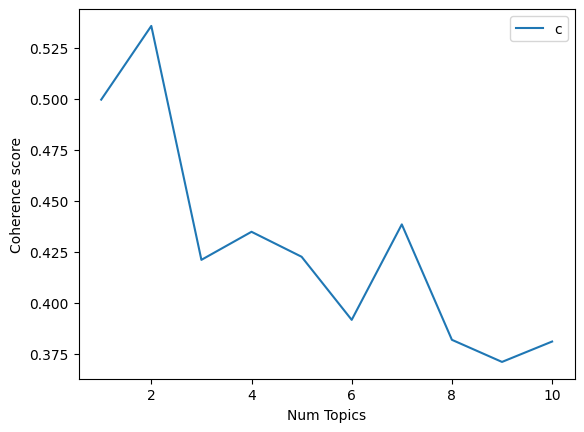

coherence_values:  [0.4996161834762738, 0.5357796532836032, 0.42104207589431614, 0.4348049393283533, 0.4225585551536849, 0.39160675557376146, 0.43843536339200734, 0.38181717995565295, 0.37097670600462324, 0.38097923350557883]


In [ ]:
start=1
limit=11
step=1
model_list, coherence_values = compute_coherence_values(id2word, corpus, tokens_negatif, start=start, limit=limit, step=step)
#show graphs
import matplotlib.pyplot as plt
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
print("coherence_values: ", coherence_values)

In [ ]:
lda_model.print_topics() #num_word default is 10
#lda_model.show_topics() #ini juga bisa

[(0,
  '0.032*"candi" + 0.029*"harus" + 0.022*"jauh" + 0.020*"terlalu" + 0.018*"kaki" + 0.016*"naik" + 0.016*"oleh" + 0.015*"berjalan" + 0.014*"atas" + 0.014*"sampai"'),
 (1,
  '0.055*"candi" + 0.054*"jauh" + 0.037*"pintu" + 0.026*"masuk" + 0.025*"lumayan" + 0.024*"naik" + 0.021*"keluar" + 0.017*"jalan" + 0.016*"cukup" + 0.013*"jarak"'),
 (2,
  '0.031*"naik" + 0.023*"candinya" + 0.019*"sayang" + 0.019*"masuk" + 0.017*"boleh" + 0.015*"kesana" + 0.014*"candi" + 0.014*"gak" + 0.014*"jalan" + 0.013*"tp"'),
 (3,
  '0.034*"masih" + 0.020*"kurang" + 0.019*"orang" + 0.019*"seperti" + 0.017*"harus" + 0.017*"tempat" + 0.016*"candi" + 0.016*"kawasan" + 0.015*"tua" + 0.015*"tapi"'),
 (4,
  '0.054*"keluar" + 0.033*"jalan" + 0.030*"jauh" + 0.029*"pintu" + 0.021*"pedagang" + 0.018*"melewati" + 0.017*"pasar" + 0.015*"harus" + 0.014*"labirin" + 0.014*"parkiran"')]

In [ ]:
print("Topic distribution for document :", " ".join(tokens_negatif[0]))
print("feature of each token:", [(id2word[id], freq) for id, freq in corpus[0]])
lda_model.get_document_topics(corpus[0])

Topic distribution for document : berada ketinggian pemandangan sekitar tampak asri tapi ya jalan menuju candinya mayan jauh orang sepuh mending nunggu taman saja tapi ya jalan menuju candinya mayan jauh tapi ya jalan menuju candinya mayan jauh orang sepuh mending nunggu taman saja
feature of each token: [('asri', 1), ('berada', 1), ('candinya', 3), ('jalan', 3), ('jauh', 3), ('ketinggian', 1), ('mayan', 3), ('mending', 2), ('menuju', 3), ('nunggu', 2), ('orang', 2), ('pemandangan', 1), ('saja', 2), ('sekitar', 1), ('sepuh', 2), ('taman', 2), ('tampak', 1), ('tapi', 3), ('ya', 3)]


[(1, 0.77598387), (2, 0.20849247)]

In [ ]:
import pandas as pd
def format_topics_sentences(ldamodel, corpus, texts):
      # Init output
      sent_topics_df = pd.DataFrame()

      # Get main topic in each document
      for i, row in enumerate(ldamodel[corpus]):
          row = sorted(row[0], key=lambda x: (x[1]), reverse=True)   # tambahkan indeks [0] pada variabel row

          # Get the Dominant topic, Perc Contribution and Keywords for each document
          for j, (topic_num, prop_topic) in enumerate(row):
              if j == 0: # => dominant topic
                   wp = ldamodel.show_topic(topic_num, 5) #get most  significant topic
                   topic_keywords = ", ".join([word for word, prop in wp])
                   sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
              else:
                   break
      sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

      # Add original text to the end of the output
      contents = pd.Series(texts)
      sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
      return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=tokens_negatif)
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Topic Keywords', 'Text']

#Save to csv
df_dominant_topic.to_csv('/content/drive/MyDrive/Colab Notebooks/doc_topic_dominant_access_negative.csv')
# Show
df_dominant_topic.head(5)

<ipython-input-20-262378c4e1d5>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
<ipython-input-20-262378c4e1d5>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
<ipython-input-20-262378c4e1d5>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
<ipython-input-20-262378c4e1d5>:15: FutureWarning: The frame.append method is deprecated and will be removed from p

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0               1              0.7760   
1            1               1              0.5708   
2            2               1              0.6634   
3            3               1              0.5492   
4            4               1              0.9737   

                       Topic Keywords  \
0  candi, jauh, pintu, masuk, lumayan   
1  candi, jauh, pintu, masuk, lumayan   
2  candi, jauh, pintu, masuk, lumayan   
3  candi, jauh, pintu, masuk, lumayan   
4  candi, jauh, pintu, masuk, lumayan   

                                                Text  
0  [berada, ketinggian, pemandangan, sekitar, tam...  
1  [apalagi, jarak, candi, pintu, keluar, parkira...  
2  [ntuk, candinya, perjalanan, jauh, tetapi, pil...  
3                 [jarak, jogja, memang, agak, jauh]  
4  [pengunjung, harus, berjalan, kaki, cukup, jau...

In [ ]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model,
texts=tokens_negatif, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.39735358389912157


In [ ]:
coherence_per_topic = coherence_model_lda.get_coherence_per_topic()
print('\nCoherence Per Topic Score: ', coherence_per_topic)


Coherence Per Topic Score:  [0.40670642961102377, 0.39129987309826414, 0.18500630762875941, 0.6099762849751669, 0.39377902418239374]


In [ ]:
pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 68.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 31.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicor

In [ ]:
pip install pandas==1.5.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 22.0 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.4
    Uninstalling pandas-2.1.4:
      Successfully uninstalled pandas-2.1.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
pyldavis 3.4.1 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.


In [ ]:
import pyLDAvis.gensim_models
import pickle
import pyLDAvis
# Visualize the topics

pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.061057 -0.025067       1        1  34.647935
1      0.068375 -0.118211       2        1  23.328842
0      0.051443 -0.099509       3        1  17.731021
2     -0.269826  0.019132       4        1  12.541340
3      0.088951  0.223655       5        1  11.750861, topic_info=         Term        Freq       Total Category  logprob  loglift
245     masih   94.000000   94.000000  Default  30.0000  30.0000
29     keluar  440.000000  440.000000  Default  29.0000  29.0000
162  pedagang  127.000000  127.000000  Default  28.0000  28.0000
94       naik  248.000000  248.000000  Default  27.0000  27.0000
31   melewati  112.000000  112.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
41      pintu   17.430342  372.756822   Topic5  -4.7843  -0.9215
4        jauh   17.892661  513.816829   Topic5  -4.7581  -1.2162
150    ketika   13.832962   60.574251   Topic5  -5.0154   0.6644
21   berjalan   14.020448   98.312875   Topic5  -5.0020   0.1936
94       naik   13.750305  248.062574   Topic5  -5.0214  -0.7514

[333 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
53        1  0.452322        agak
53        2  0.075387        agak
53        3  0.135697        agak
53        4  0.030155        agak
53        5  0.286471        agak
...     ...       ...         ...
1572      5  0.892573      wanita
182       3  0.945562      warung
635       4  0.917379         yaa
287       3  0.979532  yogyakarta
689       5  0.902016        zona

[486 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 1, 3, 4])